In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
import sys

from collections import *
from copy import deepcopy
import itertools
import json
import numpy as np
import scipy as sp
import pandas as pd
import csv


import xgboost as xgb


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
sns.set(font_scale=1.2)

from IPython.display import display
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 150

### Информация по странам и регионам

In [16]:
countries = pd.read_csv(os.path.join('data', 'countries.csv'))
countries.drop(['iso_alpha2', 'iso_numeric', 'official_name', 'name'], axis='columns', inplace=True)

regions = pd.read_csv(os.path.join('data', 'russia_regions.csv'))
regname2iso3 = dict(zip(regions.name_with_type, regions.iso_code))
regions = regions[['iso_code', 'csse_province_state', 'population', 'population_urban']]
regions['population_urban'] = regions['population_urban'] / regions['population']
regions.rename(
    columns={'iso_code': 'iso_alpha3', 'csse_province_state': 'ccse_name', 'population_urban': 'urban_pop_rate'},
    inplace=True
)

countries = pd.concat([countries, regions], sort=True)

country2iso3 = dict(zip(countries['ccse_name'], countries['iso_alpha3']))
iso32country = dict(zip(countries['iso_alpha3'], countries['ccse_name']))

### Читаем исторические данные, подготовленные в solution_prepare_data.ipynb

In [17]:
data = pd.read_csv(os.path.join('data', 'full_data_2020-05-02.csv'))
data['date'] = pd.to_datetime(data['date'])
data['deaths'] = -1

## Подготавливаем датасет

### Объединеям все даты в исторических данных и даты для прогноза

In [18]:
dates = list(data[data['country'] == 'Russia']['date'])

data_ans = pd.read_csv(os.path.join('data', 'sample_submission_stage2.csv'))
date2ind = dict(zip(dates, range(len(dates))))

dates2 = pd.to_datetime(data_ans[data_ans['region'] == 'RUS']['date'])
for e in dates2:
    if e not in date2ind:
        date2ind[e] = len(date2ind)
        dates.append(e)
print((dates[0], date2ind[dates[0]]))
print((dates[-1], date2ind[dates[-1]]))

(Timestamp('2020-01-24 00:00:00'), 0)
(Timestamp('2020-12-31 00:00:00'), 342)


### Строим датасет для объектов (iso3, date, "сдвиг в днях, на который делаем прогноз")

Например, (RU-MOW, 2020-04-15, 7) - прогноз для RU-MOW от даты 2020-04-15 на 7 дней вперед

In [25]:
CURRENT_DATE = '2020-05-02'
FORECAST_HORIZON = 7

In [22]:
df_pre_all = pd.DataFrame(
    list(itertools.product(iso32country.keys(), date2ind.keys(), range(1, FORECAST_HORIZON + 1)))
    , columns=['iso3', 'date', 'shift']
)
df_pre_all['date_ind'] = df_pre_all['date'].map(date2ind)
df_pre_all['date_pred_ind'] = (df_pre_all['date_ind'] + df_pre_all['shift'])
df_pre_all['date_pred'] = df_pre_all['date'] + df_pre_all['shift'].apply(lambda x: pd.Timedelta(days=x))

print(len(df_pre_all))
df_pre_all = df_pre_all.merge(data, how='left')#.fillna(-1)
print(len(df_pre_all))

609854
609854


In [23]:
df_pre_all[(df_pre_all['iso3'] == 'RU-MOW') & (df_pre_all.date == '2020-04-15')].sort_values(['date', 'iso3']).tail(7)

,iso3,date,shift,date_ind,date_pred_ind,date_pred,country,confirmed,deaths
430353,RU-MOW,2020-04-15,1,82,83,2020-04-16,Moscow,14776.0,-1.0
430354,RU-MOW,2020-04-15,2,82,84,2020-04-17,Moscow,14776.0,-1.0
430355,RU-MOW,2020-04-15,3,82,85,2020-04-18,Moscow,14776.0,-1.0
430356,RU-MOW,2020-04-15,4,82,86,2020-04-19,Moscow,14776.0,-1.0
430357,RU-MOW,2020-04-15,5,82,87,2020-04-20,Moscow,14776.0,-1.0
430358,RU-MOW,2020-04-15,6,82,88,2020-04-21,Moscow,14776.0,-1.0
430359,RU-MOW,2020-04-15,7,82,89,2020-04-22,Moscow,14776.0,-1.0


### Получаем таргеты для (iso3, date, сдвиг)

В качестве таргета используем **приращение заболевших** относительно даты date

Т.е. если для 'RU-MOW'
- 2020-04-15 было 14776 заболевших,
- 2020-04-16 было 16146 заболевших,
- 2020-04-16 было 18105 заболевших,

то 
- таргет для ('RU-MOW', 2020-04-15, 1) будет равен 1370,
- таргет для ('RU-MOW', 2020-04-15, 2) будет равен 3329

In [26]:
for diff in range(1, FORECAST_HORIZON + 1):
    df_pre_all.loc[(df_pre_all['shift'] == diff) & (df_pre_all['date'] <= CURRENT_DATE), 'confirmed_diff'] = -(
        df_pre_all[(df_pre_all['shift'] == diff) & (df_pre_all['date'] <= CURRENT_DATE)]
            .groupby('iso3')['confirmed'].diff(-diff)
    )

In [27]:
df_pre_all[(df_pre_all['iso3'] == 'RU-MOW') & (df_pre_all.date == '2020-04-15')].sort_values(['date', 'iso3']).tail(7)

,iso3,date,shift,date_ind,date_pred_ind,date_pred,country,confirmed,deaths,confirmed_diff
430353,RU-MOW,2020-04-15,1,82,83,2020-04-16,Moscow,14776.0,-1.0,1370.0
430354,RU-MOW,2020-04-15,2,82,84,2020-04-17,Moscow,14776.0,-1.0,3329.0
430355,RU-MOW,2020-04-15,3,82,85,2020-04-18,Moscow,14776.0,-1.0,5978.0
430356,RU-MOW,2020-04-15,4,82,86,2020-04-19,Moscow,14776.0,-1.0,9548.0
430357,RU-MOW,2020-04-15,5,82,87,2020-04-20,Moscow,14776.0,-1.0,11574.0
430358,RU-MOW,2020-04-15,6,82,88,2020-04-21,Moscow,14776.0,-1.0,14657.0
430359,RU-MOW,2020-04-15,7,82,89,2020-04-22,Moscow,14776.0,-1.0,17205.0


### Переходим в логарифмическую шкалу, исходя из метрики MALE(Mean Absolute Logarithmic Error) 

In [28]:
df_pre_all['confirmed_diff_log'] = (
    np.log10(df_pre_all['confirmed'] + df_pre_all['confirmed_diff'] + 1) - np.log10(df_pre_all['confirmed'] + 1)
)

In [29]:
df_pre_all[(df_pre_all['iso3'] == 'RU-MOW') & (df_pre_all.date == '2020-04-15')].sort_values(['date', 'iso3']).tail(7)

,iso3,date,shift,date_ind,date_pred_ind,date_pred,country,confirmed,deaths,confirmed_diff,confirmed_diff_log
430353,RU-MOW,2020-04-15,1,82,83,2020-04-16,Moscow,14776.0,-1.0,1370.0,0.038506
430354,RU-MOW,2020-04-15,2,82,84,2020-04-17,Moscow,14776.0,-1.0,3329.0,0.088236
430355,RU-MOW,2020-04-15,3,82,85,2020-04-18,Moscow,14776.0,-1.0,5978.0,0.147536
430356,RU-MOW,2020-04-15,4,82,86,2020-04-19,Moscow,14776.0,-1.0,9548.0,0.216467
430357,RU-MOW,2020-04-15,5,82,87,2020-04-20,Moscow,14776.0,-1.0,11574.0,0.251211
430358,RU-MOW,2020-04-15,6,82,88,2020-04-21,Moscow,14776.0,-1.0,14657.0,0.299263
430359,RU-MOW,2020-04-15,7,82,89,2020-04-22,Moscow,14776.0,-1.0,17205.0,0.335319


#### В логарифмической шкале приращения таргета (в период эксп роста распространения вируса) неплохо приближаются константой

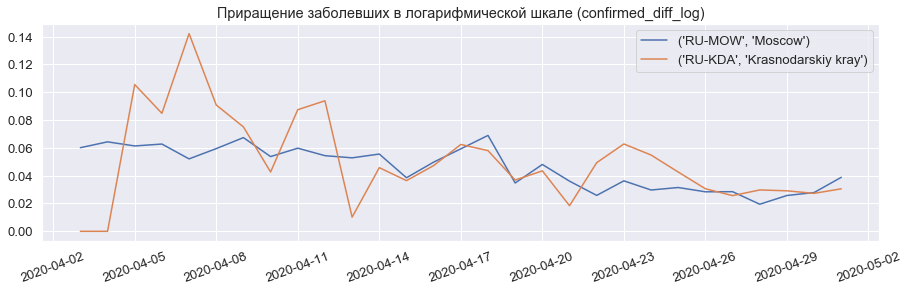

In [33]:
ind = (
    (df_pre_all['date'] >= '2020-04-03') 
    & (df_pre_all['date'] <= CURRENT_DATE) 
    & (df_pre_all['shift'] == 1)
)
plt.figure(figsize=(15, 4))
for iso3 in ['RU-MOW', 'RU-KDA']:
    plt.plot(df_pre_all[ind & (df_pre_all['iso3'] == iso3)].date, 
             df_pre_all[ind & (df_pre_all['iso3'] == iso3)].confirmed_diff_log, label=(iso3, iso32country[iso3]))
plt.legend()
plt.xticks(rotation=20)
plt.title('Приращение заболевших в логарифмической шкале (confirmed_diff_log)')
plt.show()

## Вычисляем статистические факторы по историческим данным

**Временные окна (в днях)**: 1, 2, 3, 5, 7, 10, 14, 18, 21

**Сдвиги**: 1-7 дней

**Статистики**: среднее, медиана


Например, на конкретный день X считаем фактор - "среднее приращение заболевших при прогнозе на 2 дня вперед для окна в 3 дня":

```
день (X-4), прогноз на 2 дня вперед знаем, пусть он равен A.
день (X-3), прогноз на 2 дня вперед знаем, пусть он равен B.
день (X-2), прогноз на 2 дня вперед знаем, пусть он равен C.
день (X-1), прогноз на 2 дня вперед НЕ знаем, т.к. не хотим заглядывать в будущее.
день X - значение фактора равно (A + B + C) / 3
```

In [34]:
%%time
features = defaultdict(dict)
for cc in df_pre_all['iso3'].unique():
    print(cc, end = ' ')
    for col in ['confirmed']:
        vv = df_pre_all[(df_pre_all['shift'] == 1) & (df_pre_all['iso3'] == cc)][col].values
        vv = [np.nan if e == -1 else e for e in vv]
        for i in range(len(vv)):
            for shift in range(1, FORECAST_HORIZON + 1):
                for ws in [1, 2, 3, 5, 7, 10, 14, 18, 21]:
                    real_ws = min(max(0, i - shift + 1), ws)
                    right = np.array(vv[max(0, i - real_ws + 1): max(0, i + 1)])
                    left = np.array(vv[max(0, i - shift - real_ws + 1): max(0, i - shift + 1)])
                    
                    f = np.mean(np.log10(right + 1) - np.log10(left + 1))
                    features[(cc, i)][f'f_{col}_diff_rel_ws{ws}_shift{shift}_mean'] = f
                    
                    f = np.median(np.log10(right + 1) - np.log10(left + 1))
                    features[(cc, i)][f'f_{col}_diff_rel_ws{ws}_shift{shift}_med'] = f                    
print()

AFG 

C:\Users\Alexandr\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Alexandr\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ALB DZA AND AGO ATG AZE ARG AUS AUT BHS BHR BGD ARM BRB BEL BTN BOL BIH BRA BLZ BRN BGR BLR KHM CMR CAN CPV CAF LKA TCD CHL CHN TWN COL COG COD CRI HRV CUB CYP CZE BEN DNK DMA DOM ECU SLV GNQ ETH ERI EST FJI FIN FRA DJI GAB GEO GMB DEU GHA GRC GRD GTM GIN GUY HTI VAT HND HUN ISL IND IDN IRN IRQ IRL ISR ITA CIV JAM JPN KAZ JOR KEN KOR KWT KGZ LAO LBN LVA LBR LBY LIE LTU LUX MDG MYS MDV MLT MRT MUS MEX MCO MNG MDA MNE MAR MOZ OMN NAM NPL NLD NZL NIC NER NGA NOR PAK PAN PNG PRY PER PHL POL PRT TLS QAT ROU RUS RWA LCA VCT SMR SAU SEN SRB SYC SGP SVK VNM SVN SOM ZAF ZWE ESP SDN SUR SWZ SWE CHE SYR THA TGO TTO ARE TUN TUR UGA UKR MKD EGY GBR TZA USA BFA URY UZB VEN ZMB RU-ALT RU-AMU RU-ARK RU-AST RU-BEL RU-BRY RU-VLA RU-VGG RU-VLG RU-VOR RU-MOW RU-SPE UA-40 RU-YEV RU-ZAB RU-IVA RU-IRK RU-KGD RU-KLU RU-KAM RU-KEM RU-KIR RU-KOS RU-KDA RU-KYA RU-KGN RU-KRS RU-LEN RU-LIP RU-MAG RU-MOS RU-MUR RU-NEN RU-NIZ RU-NGR RU-NVS RU-OMS RU-ORE RU-ORL RU-PNZ RU-PER RU-PRI RU-PSK RU-AD RU-AL RU-BA RU-BU RU-D

In [35]:
dff = pd.DataFrame.from_dict(features, orient='index').reset_index()
dff.columns = ['iso3', 'date_ind'] + list(dff.columns[2:])

### Статистические факторы суммарно по всем регионам/странам

Агрегируя все регионы России и все страны считаем среднее для каждой из статистик, посчитанных выше для каждого iso3 <br>
(по сути получаем среднее средних и среднее медиан внутри стран и внутри регионов России)

In [36]:
features_global = defaultdict(lambda: defaultdict(list))
for e in features:
    if e[0].find('-') != -1:
        for k, v in features[e].items():
            features_global[(1, e[1])][k + '_all'].append(v)
    else:
        for k, v in features[e].items():
            features_global[(0, e[1])][k + '_all'].append(v)
        
for e in features_global:
    for k, v in list(features_global[e].items()):
        features_global[e][k] = np.mean(v)

In [38]:
dff2 = pd.DataFrame.from_dict(features_global, orient='index').reset_index()
dff2.columns = ['is_ru', 'date_ind'] + list(dff2.columns[2:])

### Добавляем вычисленные факторы в датасет

In [39]:
df_all = df_pre_all.merge(dff)
print(df_all.shape)
df_all['is_ru'] = df_all['iso3'].apply(lambda x: x.startswith('RU-') or x .startswith('UA-')).astype(int)
df_all = df_all.merge(dff2)
print(df_all.shape)

(609854, 137)
(609854, 264)


In [40]:
print(f'Регионов России: {df_all[df_all.is_ru == 1].iso3.nunique()},'
      , f'   Стран: {df_all[df_all.is_ru == 0].iso3.nunique()}')

Регионов России: 85,    Стран: 169


### Добавляем еще несколько факторов

- population (из исходных данных)
- urban_pop_rate (из исходных данных)

- confirmed_rel - относительное число заболевших (нормируем на население)
- confirmed_ge_N - есть ли хотя бы N заболевших

In [41]:
# Избавляемся от Nan в urban_pop_rate
countries_mean = countries.mean()
countries['urban_pop_rate'] = countries['urban_pop_rate'].fillna(countries_mean['urban_pop_rate'])
countries = countries.rename(columns={'iso_alpha3': 'iso3'})

df_all = df_all.merge(countries[['iso3', 'population', 'urban_pop_rate']])

#относительное число заболевших
df_all['confirmed_rel'] = (df_all['confirmed'] + 1) / df_all['population']

#есть ли хотя бы N заболевших
for thr in [1, 2, 3, 5, 10]:
    df_all[f'confirmed_ge_{thr}'] = (df_all['confirmed'] >= thr).astype(int)

## Обучение моделей и кросс-валидация

Фиксируем последнюю известную дату LAST_KNOWN_DATE (например, дедлайн для прогнозов на вторую неделю конкурса)

- тестовая выборка: даты `[LAST_KNOWN_DATE - 6, LAST_KNOWN_DATE], все сдвиги shift=1..7`
- тренировочная выборка: `[..., LAST_KNOWN_DATE - 7] (за исключением первых двух недель), все сдвиги shift=1..7`
- выборка для финального прогноза: `[PREDICTION_DATE], все сдвиги shift=1..7`

In [91]:
def build_is_train(start_ind, start_ind_ru, last_known_date, last_known_date_ru, test_days_cnt):
    ind_train_ru = (
        (df_all['is_ru'] == 1)
        & (df_all['date_ind'] >= start_ind_ru)
        & (df_all['date_ind'] + df_all['shift'] <= date2ind[pd.Timestamp(last_known_date_ru)] - test_days_cnt)
    )
    ind_train = (
        (df_all['is_ru'] == 0)
        & (df_all['date_ind'] >= start_ind)
        & (df_all['date_ind'] + df_all['shift'] <= date2ind[pd.Timestamp(last_known_date)] - test_days_cnt)
    )
    ind_train = ind_train | ind_train_ru
    df_all['is_train'] = 0
    df_all.loc[ind_train, 'is_train'] = 1


def build_is_test(start_ind, start_ind_ru, last_known_date, last_known_date_ru, test_days_cnt):
    ind_test_ru = (
        (df_all['is_ru'] == 1)
        & (df_all['date_ind'] >= start_ind_ru)
        & (df_all['date_ind'] + df_all['shift'] > date2ind[pd.Timestamp(last_known_date_ru)] - test_days_cnt)
        & (df_all['date_ind'] + df_all['shift'] <= date2ind[pd.Timestamp(last_known_date_ru)])
    )
    ind_test = (
        (df_all['is_ru'] == 0)
        & (df_all['date_ind'] >= start_ind)
        & (df_all['date_ind'] + df_all['shift'] > date2ind[pd.Timestamp(last_known_date)] - test_days_cnt)
        & (df_all['date_ind'] + df_all['shift'] <= date2ind[pd.Timestamp(last_known_date)])
    )
    ind_test = ind_test | ind_test_ru
    df_all['is_test'] = 0
    df_all.loc[ind_test, 'is_test'] = 1


def build_is_pred(prediction_date):
    ind_pred = (df_all['date_ind'] == date2ind[pd.Timestamp(prediction_date)])

    df_all['is_pred'] = 0
    df_all.loc[ind_pred, 'is_pred'] = 1

### Подготавливаем датасеты

- для обучения
- для теста
- для прогноза
- для обучения на всех имеющихся данных (для обучения финальных моделей, которыми будем делать инференс)

Задаем веса обучающим примерам

Т.к. прогнозы на втором и третьем этапах оцениваются только по регионам России, странам можно давать меньший вес при обучении.

In [92]:
def prepare_datasets(df_all, country_weight):
    df_train = df_all[df_all['is_train'] == 1].copy()
    df_test = df_all[df_all['is_test'] == 1].copy()
    df_pred = df_all[df_all['is_pred'] == 1].copy()
    df_train_all = df_all[(df_all['is_train'] == 1) | (df_all['is_test'] == 1)].copy()

    df_train['w'] = 1
    df_train_all['w'] = 1
    df_train['w'] = df_train['w'] * (country_weight * (df_train['is_ru'] == 0).astype(int) 
                                     + 1 * (df_train['is_ru'] == 1).astype(int))
    df_train_all['w'] = df_train_all['w'] * (country_weight * (df_train_all['is_ru'] == 0).astype(int) 
                                             + 1 * (df_train_all['is_ru'] == 1).astype(int))
    
    print('Размер тренировочного датасета:', len(df_train))
    print('Размер тестового датасета:', len(df_test))
    print('Размер прогнозного датасета:', len(df_pred))
    print('Размер полного тренировочного датасета:', len(df_train_all))
    
    return df_train, df_test, df_pred, df_train_all

In [93]:
def check_null_features(df_train, df_train_all, df_test, df_pred, f_names):
    return (
        df_train[f_names + ['w', 'confirmed_diff_log']].isnull().sum().sum() == 0
        and df_test[f_names + ['confirmed_diff_log']].isnull().sum().sum() == 0
        and df_train_all[f_names + ['w', 'confirmed_diff_log']].isnull().sum().sum() == 0
        and df_pred[f_names].isnull().sum().sum() == 0
    )

In [95]:
LAST_KNOWN_DATE = '2020-04-25'
LAST_KNOWN_DATE_RU = '2020-04-26'
PREDICTION_DATE = '2020-04-26'
TEST_DAYS_CNT = 7
START_IND = 14
START_IND_RU = 14 + 14
print((dates[START_IND], dates[START_IND_RU]))

build_is_train(START_IND, START_IND_RU, LAST_KNOWN_DATE, LAST_KNOWN_DATE_RU, TEST_DAYS_CNT,)
build_is_test(START_IND, START_IND_RU, LAST_KNOWN_DATE, LAST_KNOWN_DATE_RU, TEST_DAYS_CNT)
build_is_pred(PREDICTION_DATE)

# Вес стран выбран равным 0.5 исходя из ручных запусков и оценке влияния на кросс-валидации
country_weight = 0.5
df_train, df_test, df_pred, df_train_all = prepare_datasets(df_all, country_weight=country_weight)

# выбираем финальный набор факторов
f_names = ['shift', 'confirmed_rel']
f_names += [e for e in df_all.columns if e.startswith('f_confirmed')] 
f_names += ['urban_pop_rate', 'population']
f_names += [e for e in df_all.columns if e.startswith('confirmed_ge')]
print('Число факторов: ', len(f_names))

# Убедимся, что факторах нет null-ов
assert check_null_features(df_train, df_train_all, df_test, df_pred, f_names)

(Timestamp('2020-02-07 00:00:00'), Timestamp('2020-02-21 00:00:00'))
Размер тренировочного датасета: 113169
Размер тестового датасета: 12446
Размер прогнозного датасета: 1778
Размер полного тренировочного датасета: 125615
Число факторов:  261


In [155]:
def xgb_mae(preds, dtrain):
    labels = dtrain.get_label()
    return('mae', np.mean(np.abs(labels - preds)))


def train_xgboost(df_train, df_test, df_train_all, fnames, target, xgb_params, num_rounds):
    dtrain = xgb.DMatrix(df_train[fnames], df_train[target], weight=df_train['w'])
    dtrain_all = xgb.DMatrix(df_train_all[fnames], df_train_all[target], weight=df_train_all['w'])
    dtest = xgb.DMatrix(df_test[fnames], df_test[target])
    dtest_ru = xgb.DMatrix(df_test[df_test['is_ru'] == 1][fnames], df_test[df_test['is_ru'] == 1][target])
    
    watchlist  = [(dtest_ru, 'te_ru')]
    
    evals_result = {}
    print('train')
    xgb_model = xgb.train(
        xgb_params, dtrain, num_rounds, watchlist, feval=xgb_mae, evals_result=evals_result, verbose_eval=20
    )
    print()
    print('train_all')
    xgb_model_all = xgb.train(
        xgb_params, dtrain_all, num_rounds, watchlist, feval=xgb_mae, evals_result=evals_result, verbose_eval=20
    )
    print()
    return xgb_model, xgb_model_all


def train_multiple_xgb_models(
    number_of_models, df_train, df_test, df_train_all, fnames, target, xgb_params, num_rounds
):
    models_all = []
    models = []

    for i in range(number_of_models):
        xgb_params_i = deepcopy(xgb_params)
        print(i, '===============')
        xgb_params['seed'] = i
        xgb_params['colsample_bylevel'] = 0.2 + 0.025 * (i % 3)
        xgb_model, xgb_model_all = train_xgboost(
            df_train, df_test, df_train_all, fnames, target, xgb_params, num_rounds
        )
        models.append(xgb_model)
        models_all.append(xgb_model_all)
    
    return models, models_all


def inference_xgboost(df_pred, fnames, model, ntree_limit=0):
    dpred = xgb.DMatrix(df_pred[fnames])
    preds = model.predict(dpred, ntree_limit=ntree_limit)
    return preds


def inference_multiple(df_pred, fnames, models, ntree_limit=0):
    pred = inference_xgboost(df_pred, fnames, models[0], ntree_limit=ntree_limit)
    for i in range(1, len(models)):
        pred += inference_xgboost(df_pred, fnames, models[i], ntree_limit=ntree_limit)
    return pred / len(models)


def get_predictions(df_test, models, fnames, pred_col_suff='', deboost_coef = 1.0):
    test_pred = inference_multiple(df_test, fnames, models)
    test_pred = np.maximum(test_pred, 0)
    df_test[f'pred_final{pred_col_suff}'] = deboost_coef * test_pred
    df_test[f'pred_real{pred_col_suff}'] = (
        10**(df_test[f'pred_final{pred_col_suff}'] + np.log10(df_test['confirmed'] + 1)) - 1
    ).apply(lambda x: int(x + 0.5))

## Обучаем деревянную xgboost модель

**Деревья не умеют прогнозировать тренд**, но, благодаря тому что в качестве таргета используются приращения, эта проблема решается.

In [162]:
xgb_params = {
    'objective': 'reg:linear',
    'max_depth': 4, 
    'min_child_weight': 10, 
    'learning_rate': 0.07,
    'colsample_bylevel':  0.2,
    'silent': False,
    'seed': 0,
    'booster': 'gbtree',
    #'alpha': 4,
    #'beta': 1,
}

target = 'confirmed_diff_log'
num_rounds = 120
number_of_models = 10
models, models_all = train_multiple_xgb_models(
    number_of_models, df_train, df_test, df_train_all, f_names, target, xgb_params, num_rounds
)

# Для тестовой выборки используем модель, обученную на тренировочной выборке
get_predictions(df_test, models, f_names)
# Для прогнозной выборки используем финальную модель
get_predictions(df_pred, models_all, f_names)

# Для прогнозной выборки для второго сабмита уменьшаем все прогнозы на 10%
get_predictions(df_pred, models_all, f_names, pred_col_suff='_v2', deboost_coef=0.9)

0 ===============
train
[0]	te_ru-rmse:0.304329	te_ru-mae:0.274147
[20]	te_ru-rmse:0.136762	te_ru-mae:0.110918
[40]	te_ru-rmse:0.118862	te_ru-mae:0.083087
[60]	te_ru-rmse:0.113362	te_ru-mae:0.074917
[80]	te_ru-rmse:0.111959	te_ru-mae:0.073193
[100]	te_ru-rmse:0.110667	te_ru-mae:0.072201
[119]	te_ru-rmse:0.110046	te_ru-mae:0.071779

train_all
[0]	te_ru-rmse:0.302087	te_ru-mae:0.271984
[20]	te_ru-rmse:0.133929	te_ru-mae:0.109015
[40]	te_ru-rmse:0.112415	te_ru-mae:0.079558
[60]	te_ru-rmse:0.104758	te_ru-mae:0.069973
[80]	te_ru-rmse:0.102233	te_ru-mae:0.067639
[100]	te_ru-rmse:0.100712	te_ru-mae:0.066663
[119]	te_ru-rmse:0.099567	te_ru-mae:0.065872

1 ===============
train
[0]	te_ru-rmse:0.303129	te_ru-mae:0.271664
[20]	te_ru-rmse:0.135569	te_ru-mae:0.110797
[40]	te_ru-rmse:0.115856	te_ru-mae:0.080525
[60]	te_ru-rmse:0.112992	te_ru-mae:0.074946
[80]	te_ru-rmse:0.111569	te_ru-mae:0.073217
[100]	te_ru-rmse:0.110733	te_ru-mae:0.072358
[119]	te_ru-rmse:0.109857	te_ru-mae:0.071912

train_all
[0

### Посмотрим на важность факторов в деревянной модели

- логично, что самым важным фактором является сдвиг - т.е. то, насколько далеко вперед хочется сделать прогноз

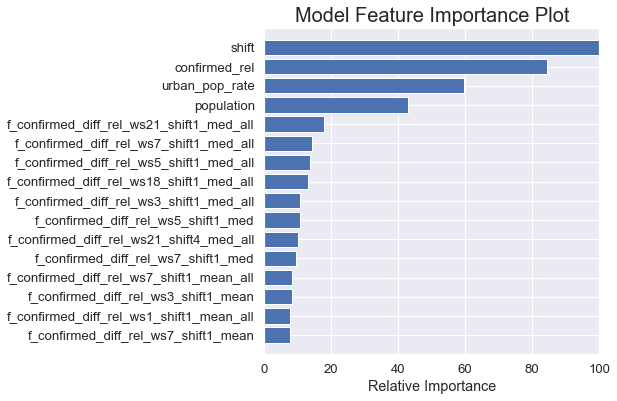

In [150]:
from feature_importance import get_feature_importance, draw_feature_importance
draw_feature_importance(
    get_feature_importance(f_names, models_all[0]),
    topn=16
)

### Посмотрим на прогнозы

In [163]:
def draw_forecast(iso3_list, df_all, df_pred, pred_columns):
    plt.figure(figsize=(16, 10))
    for i, iso3 in enumerate(iso3_list):
        plt.subplot(2, 2, i + 1)
        baz_tr = df_all[(df_all['iso3'] == iso3) & (df_all['shift'] == 1) & (df_all['confirmed'] > 0)]
        plt.plot(baz_tr['date'], baz_tr['confirmed'], label='истинное значение', marker='o')
        baz_pr = df_pred[(df_pred['iso3'] == iso3)]
        for col, col_label in pred_columns.items():
            plt.plot(baz_pr['date_pred'], baz_pr[col], label=col_label, marker='o')

        plt.xlim(['2020-04-01', None])
        plt.xticks(rotation=20)
        plt.legend()
        
        plt.title((iso3, iso32country[iso3]))
    plt.tight_layout()
    plt.show()

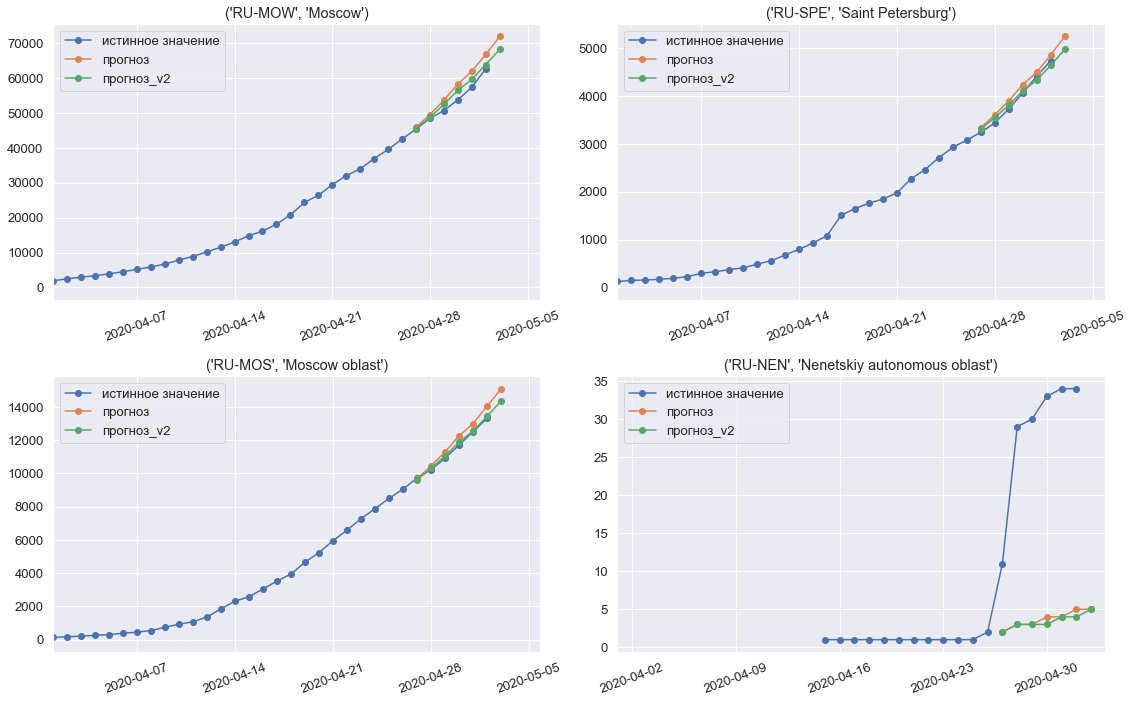

In [164]:
draw_forecast(['RU-MOW', 'RU-SPE', 'RU-MOS', 'RU-NEN'], df_all, df_pred, 
              {'pred_real': 'прогноз', 'pred_real_v2': 'прогноз_v2'})

### Сохраним прогноз

In [165]:
def save_predictions(df_pred, filename, pred_col='pred_real'):
    data_ans = pd.read_csv(os.path.join('data', 'sample_submission_stage2.csv'))
    data_ans = data_ans.rename(columns={'region': 'iso3'})

    final_df = df_pred[['iso3', 'date_pred', 'shift', pred_col]].copy()
    final_df['date'] = final_df['date_pred'].astype(str)
    final_df

    data_ans = data_ans.merge(final_df, how='left')

    data_ans.loc[~data_ans[pred_col].isnull(), 'prediction_confirmed'] = (
        data_ans.loc[~data_ans[pred_col].isnull(), pred_col]
    ).astype(int)

    data_ans['country'] = data_ans['iso3']

    baz = data_ans[['date', 'country', 'prediction_confirmed', 'prediction_deaths']].copy()
    baz.to_csv(os.path.join('submissions', filename), encoding='utf-8', index=False)    

In [168]:
save_predictions(df_pred, 'baseline_submission_week3_without_hack.csv')

In [169]:
save_predictions(df_pred, 'baseline_submission_week3_without_hack_0.9.csv', pred_col='pred_real_v2')

# Фактор случайности - Ненецкая АО и некорректные данные

В качестве исходных данных для финальных сабмитов я использовал только данные из таблицы Роспотребнадзора
https://docs.google.com/spreadsheets/d/1Re1TOpN32DY6_iFQNfY8D-bFqBw_gMQKZG7Mg7iRNqQ

В них была серьезная ошибка для Ненецкой АО и для некоторых других регионов(но не такая большая).
- Табличка: для RU-NEN на 26.04 как будто бы было 28 заболевших (перепутали при заполнении два раза Ненецкую АО и Ямало-Ненецкий АО)
- Факт: для RU-NEN на 26.04 реально только 2 заболевших


<p style="color: red">Фактор случайности в том, что 27.04 и 28.04 в RU-NEN добавилось **11 и 18** заболевших</h3></p>

На графике выше можно видеть, что модель, обученная на корректных данных, такой резкий скачок НЕ предсказывает.

С выбранной организаторами функцией штрафа - штраф за один лишь этот регион в каком-то смысле "перекрывает" старания и точность прогнозов на всех остальных регионах.

### Сравним качество прогнозов или "что было бы, если бы я обучался на корректных данных" 

In [180]:
def analyze(dates, data, subs, iso3_list = None):
    scores = dict()
    for ff in subs:
        scores[ff] = []
        subm = pd.read_csv(os.path.join('submissions', ff))
        subm['date'] = pd.to_datetime(subm['date'])
        subm.columns = ['date', 'iso3', 'prediction_confirmed' ,'prediction_deaths']
        for date in dates:
            ddf = subm[subm['date'] == date].merge(data, how='left')
            if iso3_list is not None:
                ddf = ddf[ddf.iso3.isin(iso3_list)]
            ddf['score'] = abs(np.log10((ddf['prediction_confirmed'] + 1) / (ddf['confirmed'] + 1)))
            reg2score = dict(zip())
            score = np.mean(ddf['score'])
            scores[ff].append(score)
        scores[ff] = [np.sum(scores[ff])] + scores[ff]
    return scores

In [181]:
ind_ru = data.iso3.apply(lambda x: str(x).find('-') != -1)
ru = data[ind_ru].iso3.unique()
len(ru)

85

In [182]:
subs_stage3 = [
    'baseline_submission_week3.csv', 
    'baseline_submission_week3_0.9.csv', 
    'baseline_submission_week3_without_hack.csv',
    'baseline_submission_week3_without_hack_0.9.csv'
]
dates = pd.date_range('20200427', '20200502')
scores = analyze(dates, data, subs_stage3, ru)
pd.DataFrame(scores, index=['Total'] + [str(e) for e in dates]).T

,Total,2020-04-27 00:00:00,2020-04-28 00:00:00,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00
baseline_submission_week3.csv,0.256807,0.023614,0.030670,0.042148,0.047804,0.053919,0.058653
baseline_submission_week3_0.9.csv,0.232286,0.023552,0.029732,0.038088,0.043433,0.046490,0.050991
baseline_submission_week3_without_hack.csv,0.290384,0.024064,0.038444,0.049830,0.055531,0.059426,0.063089
baseline_submission_week3_without_hack_0.9.csv,0.280257,0.024359,0.037794,0.046622,0.052896,0.057269,0.061317


### Без RU-NEN

Видно, что без RU-NEN качество моделей без случайного фактора и с ним было бы сравнимо.

In [183]:
subs_stage3 = [
    'baseline_submission_week3.csv', 
    'baseline_submission_week3_0.9.csv', 
    'baseline_submission_week3_without_hack.csv',
    'baseline_submission_week3_without_hack_0.9.csv'
]
dates = pd.date_range('20200427', '20200502')
scores = analyze(dates, data, subs_stage3, [e for e in ru if e != 'RU-NEN'])
pd.DataFrame(scores, index=['Total'] + [str(e) for e in dates]).T

,Total,2020-04-27 00:00:00,2020-04-28 00:00:00,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00
baseline_submission_week3.csv,0.246466,0.018824,0.030092,0.041205,0.046810,0.052614,0.056921
baseline_submission_week3_0.9.csv,0.222707,0.018761,0.029143,0.037224,0.042617,0.045411,0.049551
baseline_submission_week3_without_hack.csv,0.236580,0.017184,0.028484,0.039836,0.046281,0.050073,0.054722
baseline_submission_week3_without_hack_0.9.csv,0.224236,0.017482,0.027827,0.036590,0.042461,0.047890,0.051986


In [219]:
def compare_region(iso3, subs):
    plt.figure(figsize=(10, 5))
    baz_tr = df_all[(df_all['iso3'] == iso3) & (df_all['shift'] == 1) & (df_all['confirmed'] > 0)]
    plt.plot(baz_tr['date'], baz_tr['confirmed'], label='истинное значение', marker='o')

    for ff in subs:
        subm = pd.read_csv(os.path.join('submissions', ff))
        subm['date'] = pd.to_datetime(subm['date'])
        subm.columns = ['date', 'iso3', 'prediction_confirmed' ,'prediction_deaths']

        baz_pr = subm[(subm['iso3'] == iso3) & (subm['date'] >= '2020-04-27') & (subm['date'] <= '2020-05-03')]
        
        ddf = baz_pr.merge(data, how='left')
        ddf['score'] = abs(np.log10((ddf['prediction_confirmed'] + 1) / (ddf['confirmed'] + 1)))
        score = ddf['score'].sum() / df_all[df_all['is_ru'] == 1].iso3.nunique()
        plt.plot(baz_pr['date'], baz_pr['prediction_confirmed'], 
                 label='score={:.4f}, {}'.format(score, ff.replace('.csv', '')), marker='o')

    plt.xlim(['2020-04-16', None])
    plt.xticks(rotation=20)
    plt.legend()

    plt.title((iso3, iso32country[iso3]))
    plt.tight_layout()
    plt.show()

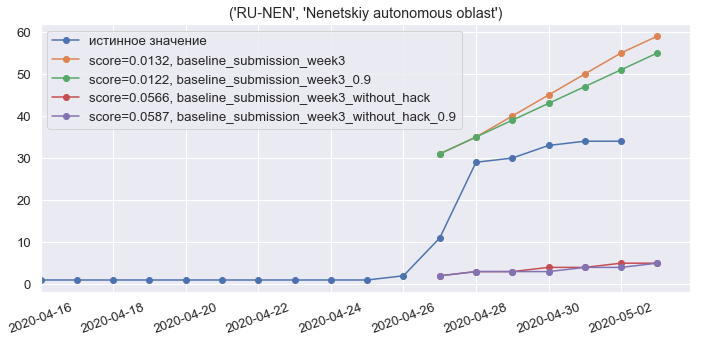

In [220]:
compare_region('RU-NEN', subs_stage3)

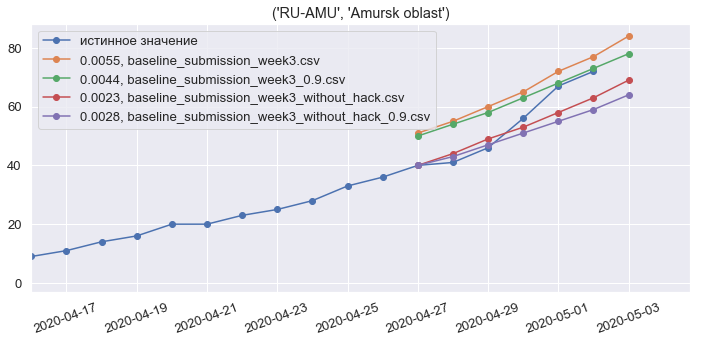

In [218]:
compare_region('RU-AMU', subs_stage3)